# SpikeInterface Tutorial -  GDR School Lyon - Marseille 2023


In this practice, you will use SpikeInterface to analyze a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. 
The dataset is kindly provided by [Samuel McKenzie's Lab](https://mckenzieneurolab.com/). 

The objective of this practice is for you to familiarize with SpikeInterface on a real-world example and to explore its capabilities and functionalities.

This notebook is very similar to the demo.

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Viewers](#viewers)
* [8. Validation and curation](#curation)
* [9. Spike sorting comparison](#comparison)


# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording (you should have this already). Feel free to use your own recordings as well later on. 

The dataset is called `cambridge_data.dat` and can be found on this [drive link](https://docs.google.com/document/d/16Vn5fUkTFp6gmHykJItJZEsdvoLe-OmkXgEHhO3Yliw/edit?usp=sharing).

Move the dataset in a folder on your local machine.

The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib widget

In [4]:
import spikeinterface.full as si

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path



# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [6]:
# base folder is where I put my cambridge_data.dat file
# base_folder = Path('/media/samuel/dataspikesorting/DataSpikeSorting/SI_tutorial_Marseille/')
base_folder = Path('/home/samuel/DataSpikeSorting/SI_tutorial_marseille_2023/')



In [7]:
si.read_binary?

Init signature:
si.read_binary(
    file_paths,
    sampling_frequency,
    dtype,
    num_channels=None,
    t_starts=None,
    channel_ids=None,
    time_axis=0,
    file_offset=0,
    gain_to_uV=None,
    offset_to_uV=None,
    is_filtered=None,
    num_chan=None,
)
Docstring:     
RecordingExtractor for a binary format

Parameters
----------
file_paths: str or Path or list
    Path to the binary file
sampling_frequency: float
    The sampling frequency
num_channels: int
    Number of channels
num_chan: int [deprecated, use num_channels instead, will be removed as early as v0.100.0]
    Number of channels
dtype: str or dtype
    The dtype of the binary file
time_axis: int
    The axis of the time dimension (default 0: F order)
t_starts: None or list of float
    Times in seconds of the first sample for each segment
channel_ids: list (optional)
    A list of channel ids
file_offset: int (optional)
    Number of bytes in the file to offset by during memmap instantiation.
gain_to_uV: f

In [8]:
# file path
recording_file = base_folder / 'cambridge_data.dat'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype = "int16"
time_axis = 0

In [9]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/binaryrecordingextractor.py:77: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [10]:
print(recording)

BinaryRecordingExtractor: 64 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                          600.00s (10.00 minutes) - int16 dtype - 1.43 GiB
  file_paths: ['/home/samuel/DataSpikeSorting/SI_tutorial_marseille_2023/cambridge_data.dat']


We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [11]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [12]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


### Exercise 1a) Explore traces

Explore the `recording.get_traces()` function. What are its arguments? What is the shape of the returned signals? What is the unit? 

Try to plot the traces of some channels using `matplotlib`.

### 1a) SOLUTION

In [13]:
# we have to extract only a chunk of the traces (let's say 5 seconds) otherwise the data would not fit on our RAM

# we can extract traces as raw int16 (default) as:
traces = recording.get_traces(start_frame=10*fs, end_frame=15*fs)

Text(0, 0.5, 'raw ADC output')

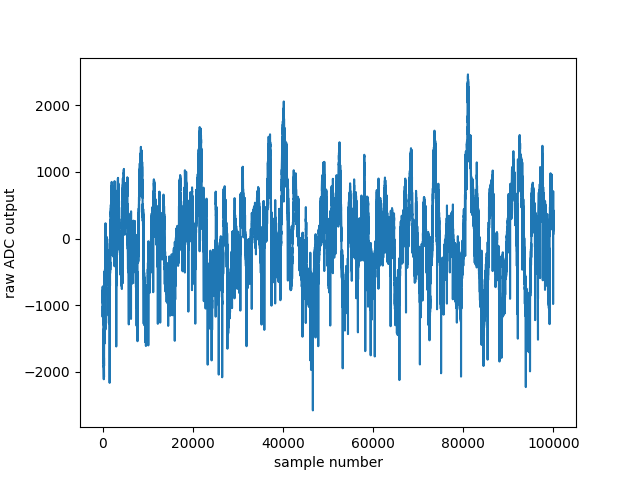

In [14]:
fix, ax = plt.subplots()
ax.plot(traces[:, 4])
ax.set_xlabel("sample number")
ax.set_ylabel("raw ADC output")

In [15]:
# we can extract traces in uV with the return_scaled argument
traces_uV = recording.get_traces(start_frame=10*fs, end_frame=15*fs, return_scaled=True)

Text(0, 0.5, '$\\mu$V')

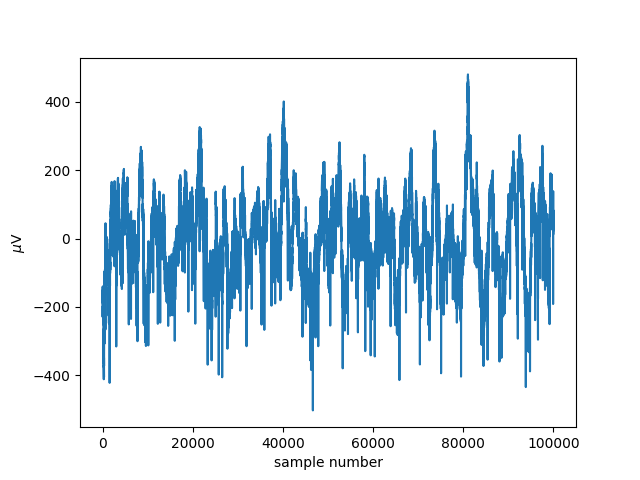

In [16]:
fix, ax = plt.subplots()
ax.plot(traces_uV[:, 4])
ax.set_xlabel("sample number")
ax.set_ylabel("$\mu$V")

**IMPORTANT**: The `widgets` module includes several convenient plotting functions that can be used to explore the data:

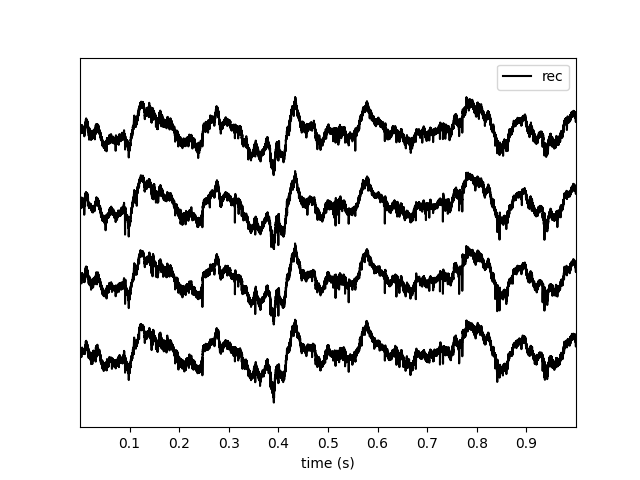

In [17]:
w_ts = si.plot_traces(recording, channel_ids=[0, 1, 2, 3], backend='matplotlib')

In [18]:
%matplotlib widget
w_ts = si.plot_traces(recording, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [19]:
import probeinterface as pi
from probeinterface import plotting

In [20]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch - 4shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [21]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [22]:
probe.wiring_to_device('ASSY-156>RHD2164')

(<matplotlib.collections.PolyCollection at 0x7f89b1fb8670>,
 <matplotlib.collections.PolyCollection at 0x7f89b2146ec0>)

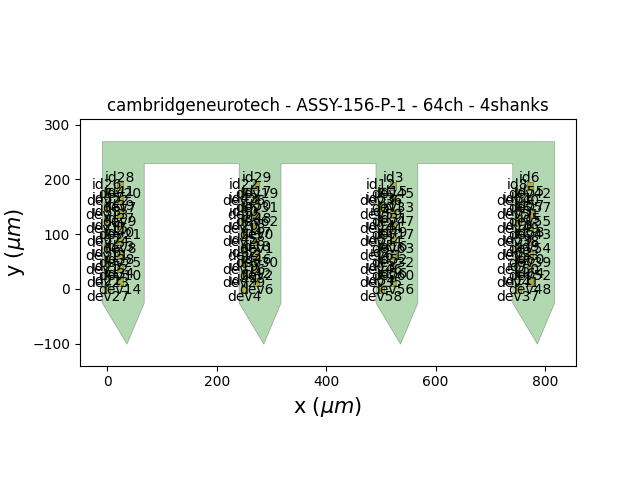

In [23]:
plotting.plot_probe(probe, with_contact_id=True, with_device_index=True)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [24]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,2,47
1,2,2,46
2,3,2,45
3,4,2,44
4,5,3,43
...,...,...,...
59,60,3,52
60,61,3,51
61,62,3,50
62,63,3,49


Note that also the `shank_id` is loaded with the probe.

In [25]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [26]:
probe_rec = recording_prb.get_probe()
df = probe_rec.to_dataframe(complete=True)
# df.loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]
df

,x,y,contact_shapes,width,height,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,272.5,112.5,rect,11.0,15.0,1,48,0,um,1.0,0.0,0.0,1.0
1,272.5,87.5,rect,11.0,15.0,1,47,1,um,1.0,0.0,0.0,1.0
2,272.5,37.5,rect,11.0,15.0,1,46,2,um,1.0,0.0,0.0,1.0
3,250.0,75.0,rect,11.0,15.0,1,45,3,um,1.0,0.0,0.0,1.0
4,250.0,0.0,rect,11.0,15.0,1,44,4,um,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,500.0,150.0,rect,11.0,15.0,2,53,59,um,1.0,0.0,0.0,1.0
60,522.5,37.5,rect,11.0,15.0,2,52,60,um,1.0,0.0,0.0,1.0
61,500.0,75.0,rect,11.0,15.0,2,51,61,um,1.0,0.0,0.0,1.0
62,272.5,137.5,rect,11.0,15.0,1,50,62,um,1.0,0.0,0.0,1.0


In [27]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [28]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [29]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (group `0`) for the following analysis:

In [30]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                       600.00s (10.00 minutes) - int16 dtype - 366.21 MiB, 1: ChannelSliceRecording: 16 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                       600.00s (10.00 minutes) - int16 dtype - 366.21 MiB, 2: ChannelSliceRecording: 16 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                       600.00s (10.00 minutes) - int16 dtype - 366.21 MiB, 3: ChannelSliceRecording: 16 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                       600.00s (10.00 minutes) - int16 dtype - 366.21 MiB}


In [31]:
group_to_sort = 0

In [32]:
recording_to_process = recordings_by_group[0]

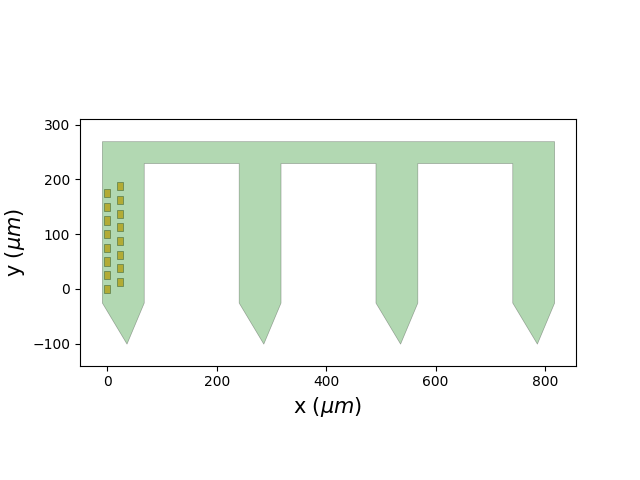

In [33]:
si.plot_probe_map(recording_to_process)

Below, we bandpass filter the recording:

In [34]:
recording_f = si.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)


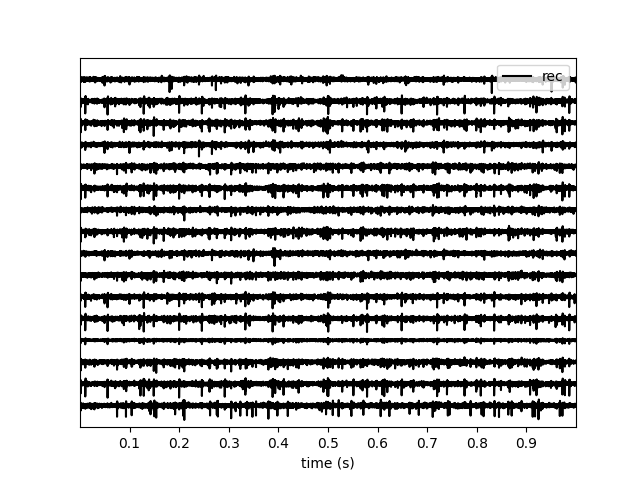

In [35]:
w = si.plot_traces(recording_f)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

### Exercise 2a) Explore noise reduction methods

We can use the `preprocessing` module to further increase the quality of the traces before spike sorting.
Several available preprocessors are available for this purpose.

- Explore the `spikeinterface.preprocessing` module to find functions that could remove noise (e.g. by re-referencing the signal).

- Choose a preprocessing step and apply it to the filtered recording (`recording_f`)

- Compare the traces to the filtered traces

### 2a) SOLUTION 


We are going to use toe `common_reference` function. Depending on the nature of noise, other preprocessing steps may be appropriate:

* `remove_bad_channels`: some channels have very high noise compared to others
* `notch_filter`: 50-60Hz line interference or localized noise sources
* `remove_artifacts`: blank out or interpolate artifacts due to, for example, electrical stimulation

In [36]:
si.common_reference?

Init signature:
si.common_reference(
    recording,
    reference='global',
    operator='median',
    groups=None,
    ref_channel_ids=None,
    local_radius=(30, 55),
    verbose=False,
    dtype=None,
)
Docstring:     
Re-references the recording extractor traces.

Parameters
----------
recording: RecordingExtractor
    The recording extractor to be re-referenced
reference: str 'global', 'single' or 'local'
    If 'global' then CMR/CAR is used either by groups or all channel way.
    If 'single', the selected channel(s) is remove from all channels. operator is no used in that case.
    If 'local', an average CMR/CAR is implemented with only k channels selected the nearest outside of a radius around each channel
operator: str 'median' or 'average'
    If 'median', common median reference (CMR) is implemented (the median of
        the selected channels is removed for each timestamp).
    If 'average', common average reference (CAR) is implemented (the mean of the selected channels is

In [37]:
recording_cmr_global = si.common_reference(recording_f, reference="global", operator="median")

In [38]:
recording_cmr_local = si.common_reference(recording_f, reference="local", operator="median", local_radius=(30, 55),)

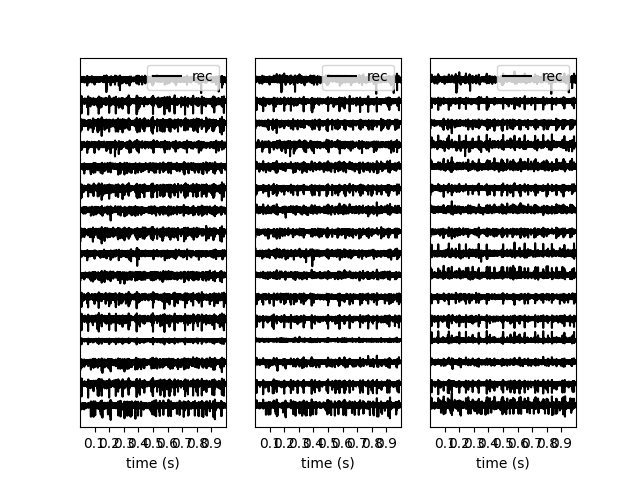

In [39]:
fig, axs = plt.subplots(ncols=3)
si.plot_traces(recording_f, ax=axs[0])
si.plot_traces(recording_cmr_global, ax=axs[1])
si.plot_traces(recording_cmr_local, ax=axs[2])

In [41]:
si.plot_traces({'filtered': recording_f, 'global':recording_cmr_global, 'local':recording_cmr_local}, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [42]:
# Use the right object to continue with the analysis
recording_processed = recording_f

### Exercise 2b) Visual exploration preprocessing methods with the `ephyviewer` backend

In [43]:
# %gui qt
# si.plot_traces(recording_processed, backend='ephyviewer')

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [44]:
fs = recording_processed.get_sampling_frequency()
recording_sub = recording_processed.frame_slice(start_frame=0*fs, end_frame=300*fs)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [45]:
recording_saved = recording_sub.save(folder=base_folder / "preprocessed", 
                                     n_jobs=4, chunk_duration="1s", progress_bar=True, )

write_binary_recording with n_jobs = 4 and chunk_size = 20000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

The `save` returns a new *cached* recording that has all the previously loaded information:

In [46]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after caching: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


After saving the SI object, we can easily load it back in a new session:

In [47]:
recording_loaded = si.load_extractor(base_folder / "preprocessed")
recording_loaded

BinaryFolderRecording: 16 channels - 20.0kHz - 1 segments - 6,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 183.11 MiB

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording.

Let's first check the installed sorters in SpikeInterface.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [48]:
si.installed_sorters()

['mountainsort5', 'spykingcircus2', 'tridesclous', 'tridesclous2']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [49]:
sorter_name = 'tridesclous'
# sorter_name = 'spykingcircus2'


In [50]:
si.get_default_sorter_params(sorter_name)

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'common_ref_removal': False,
 'nested_params': None,
 'n_jobs': 12,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [51]:
si.get_sorter_params_description(sorter_name)

{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'common_ref_removal': 'remove common reference with median',
 'n_jobs': 'Number of jobs (when saving ti binary) - default -1 (all cores)',
 'chunk_size': 'Number of samples per chunk (when saving ti binary) - default global',
 'chunk_memory': "Memory usage for each job (e.g. '100M', '1G') (when saving to binary) - default global",
 'total_memory': "Total memory usage (e.g. '500M', '2G') (when saving to binary) - default global",
 'chunk_duration': "Chunk duration in s if float or with units if str (e.g. '1s', '500ms') (when saving to binary) - default global",
 'progress_bar': 'If True, progress bar is shown (when saving to binary) - default global'}

### Exercise 4a) Spike sort your data

The `si.run_sorter()` function from the `sorters` module is where the spike sorting happens! The function returns a `SortingExtractor` object, which allows you to retrieve spiking data (e.g. unit ids, spike trains, etc.)

Run a spike sorter installed on your system and explore the returned `SortingExtractor` object.

In [52]:
si.run_sorter?

Signature:
si.run_sorter(
    sorter_name: str,
    recording: spikeinterface.core.baserecording.BaseRecording,
    output_folder: Optional[str] = None,
    remove_existing_folder: bool = False,
    delete_output_folder: bool = False,
    verbose: bool = False,
    raise_error: bool = True,
    docker_image: Union[bool, str, NoneType] = False,
    singularity_image: Union[bool, str, NoneType] = False,
    delete_container_files: bool = True,
    with_output: bool = True,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name: str
    The sorter name
recording: RecordingExtractor
    The recording extractor to be spike sorted
output_folder: str or Path
    Path to output folder
remove_existing_folder: bool
    If True and output_folder exists yet then delete.
delete_output_folder: bool
    If True, output folder is deleted (default False)
verbose: bool
    If True, output is verbose
raise_error: bool
    If True, an 

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

### 4a) SOLUTION

In [ ]:
# run spike sorting on recording
sorting_TDC = si.run_sorter(sorter_name=sorter_name, recording=recording_saved,
                        output_folder=base_folder / f"output_{sorter_name}", verbose=True)

In [57]:
print(sorting_TDC)

print("Unit ids:", sorting_TDC.get_unit_ids())

TridesclousSortingExtractor: 13 units - 1 segments - 20.0kHz
Unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [58]:
print("Spike train of unit 0:", sorting_TDC.get_unit_spike_train(0))

Spike train of unit 0: [ 184331  290888  607831  695859 1006641 1143632 1235753 1926059 2032458
 2176734 2184410 2289667 2322125 2363377 2418855 2420048 2428866 2430306
 2590879 2591100 2592314 2594377 2601667 2607280 2624790 2642031 2645620
 2645726 2645982 2646317 2650936 2652423 2653022 2654212 2654700 2678030
 2715269 2722235 2736992 2738979 2739342 2741165 2742579 2744043 2745032
 2745249 2745745 2745889 2746568 2747324 2754160 2758606 2759023 2759368
 2759452 2761658 2762752 2765129 2766066 2766506 2768287 2771469 2773716
 2774849 2775912 2776289 2777346 2780149 2780904 2781849 2790668 2792063
 2795326 2810181 2812522 2815170 2817028 2821294 2822395 2824154 2832967
 2833680 2834473 2834724 2842430 2913537 2979292 3018718 3117643 3127063
 3430081 3445231 3468140 3469417 3470996 3510105 3511065 3511355 3511437
 3511574 3512347 3531806 3533126 3537712 3539243 3541354 3549680 3549776
 3551930 3562595 3563241 3564154 3564697 3571784 3578465 3579156 3585226
 3603693 3637880 3819659 382

### Exercise 4b) Change a spike sorter parameter

Parameters (listed above) can be directly passed as extra arguments to the `si.run_sorter()` function.

Try to choose a parameter, change its default value, and run spike sorting again


### 4b) SOLUTION

Let's try to increase the detection threshold!

In [59]:
params = si.get_default_sorter_params(sorter_name)
params

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'common_ref_removal': False,
 'nested_params': None,
 'n_jobs': 12,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [60]:
# run spike sorting on entire recording
sorting_other_params = si.run_sorter(sorter_name=sorter_name, recording=recording_saved,
                         output_folder=base_folder / f"output_{sorter_name}_new_params", verbose=True, detect_threshold=7)

DataIO <id: 140226797750448> 
  workdir: /home/samuel/DataSpikeSorting/SI_tutorial_marseille_2023/output_tridesclous_new_params/sorter_output
  sample_rate: 20000.0
  total_channel: 16
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch12 ch13 ch14 ch15]
  nb_segment: 1
  length: 6000000
  durations: 300.0 s.
catalogue_nested_params
{'chunksize': 20000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 300.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_le

In [61]:
print(sorting_other_params)

print("Unit ids:", sorting_other_params.get_unit_ids())

TridesclousSortingExtractor: 13 units - 1 segments - 20.0kHz
Unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


## exercice 4c

Install and run anoyther sorter for instance : tridesclous, mountainsort5



## Solution 4c

In [62]:
sorting_MS5 = si.run_sorter(sorter_name="mountainsort5", recording=recording_saved,
                         output_folder=base_folder/f"output_MS5", verbose=True)

Warning! The recording is already filtered, but mountainsort5 filter is enabled
filtering
whitening
Number of channels: 16
Number of timepoints: 6000000
Sampling frequency: 20000 Hz
Channel 0: [ 22.5 162.5]
Channel 1: [22.5 87.5]
Channel 2: [ 22.5 137.5]
Channel 3: [22.5 37.5]
Channel 4: [ 0. 75.]
Channel 5: [ 0. 50.]
Channel 6: [  0. 150.]
Channel 7: [22.5 12.5]
Channel 8: [  0. 125.]
Channel 9: [ 22.5 187.5]
Channel 10: [ 22.5 112.5]
Channel 11: [  0. 175.]
Channel 12: [ 0. 25.]
Channel 13: [  0. 100.]
Channel 14: [22.5 62.5]
Channel 15: [0. 0.]
Loading traces
Detecting spikes

Adjacency for detect spikes with channel radius 200
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7,

In [63]:
print(sorting_MS5)

print("Unit ids:", sorting_MS5.get_unit_ids())

NpzSortingExtractor: 31 units - 1 segments - 20.0kHz
  file_path: /home/samuel/DataSpikeSorting/SI_tutorial_marseille_2023/output_MS5/sorter_output/firings.npz
Unit ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


## excercie 4d (optional)

Spike sort in Docker containers

If you have docker installed try to play with the **docker_image** option
For instance::
  * `docker_image="spikeinterface/spyking-circus-base:1.0.7"`
  * `docker_image=True`

And try to run spkykingcircus.


## Solution 4d

In [102]:
sorting_SC = si.run_spykingcircus(recording_saved, output_folder=base_folder/"results_SC",
                                  docker_image="spikeinterface/spyking-circus-base:1.0.7",
                                  verbose=True)

Starting container
Installing spikeinterface from sources in spikeinterface/spyking-circus-base:1.0.7
Installing dev spikeinterface from remote repository
Running spykingcircus sorter inside spikeinterface/spyking-circus-base:1.0.7
Stopping container


In [103]:
print(sorting_SC)

print("Unit ids:", sorting_SC.get_unit_ids())

SpykingCircusSortingExtractor: 46 units - 1 segments - 20.0kHz
Unit ids: [ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3
 30 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45  5  6  7  8  9]


/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


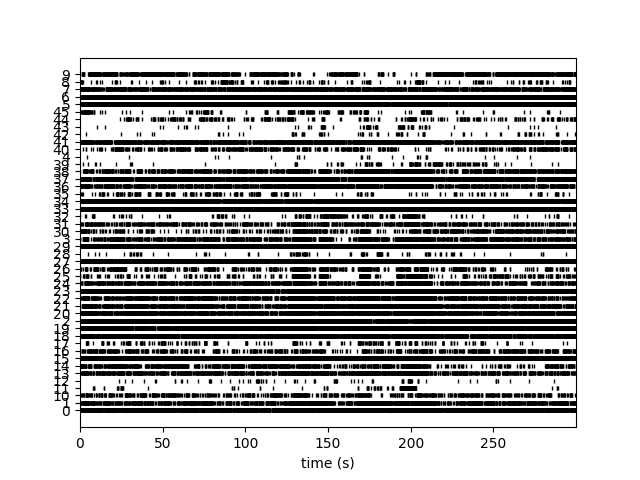

In [104]:
si.plot_rasters(sorting_SC)

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [64]:
sorting = sorting_TDC

In [65]:
si.extract_waveforms?

Signature:
si.extract_waveforms(
    recording,
    sorting,
    folder=None,
    mode='folder',
    precompute_template=('average',),
    ms_before=1.0,
    ms_after=2.0,
    max_spikes_per_unit=500,
    overwrite=False,
    return_scaled=True,
    dtype=None,
    sparse=True,
    sparsity=None,
    num_spikes_for_sparsity=100,
    allow_unfiltered=False,
    use_relative_path=False,
    seed=None,
    load_if_exists=None,
    **kwargs,
)
Docstring:
Extracts waveform on paired Recording-Sorting objects.
Waveforms can be persistent on disk (`mode`="folder") or in-memory (`mode`="memory").
By default, waveforms are extracted on a subset of the spikes (`max_spikes_per_unit`) and on all channels (dense).
If the `sparse` parameter is set to True, a sparsity is estimated using a small number of spikes
(`num_spikes_for_sparsity`) and waveforms are extracted and saved in sparse mode.


Parameters
----------
recording: Recording
    The recording object
sorting: Sorting
    The sorting object


In [66]:
job_kwargs = dict(n_jobs=4, chunk_duration='1s',  progress_bar=True)

In [67]:
we = si.extract_waveforms(recording_saved, sorting_TDC, folder=base_folder/"waveforms_TDC", sparse=False, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 16 channels - 13 units - 1 segments
  before:20 after:40 n_per_units:500


Now all waveforms are computed and stored in the provided `waveforms_TDC` folder. We can now retrieve waveforms and templates easily.

### Exercise 5a) Explore waveforms and templates

The `WaveformExtractor` object (`we`) has convenient functions to retrieve waveforms and templates (average waveforms).

- Retrieve some waveforms and templates and inspect them
- Are waveform extracted from all spikes? If not, can you explore the function docs and find a way to compute waveforms for all spikes?


### 5a) SOLUTION

We can access waveforms for single units with the `get_waveforms` and `get_template` functions. 


In [68]:
waveforms0 = we.get_waveforms(unit_id=0)
template0 = we.get_template(unit_id=0)

print(waveforms0.shape)
print(template0.shape)

(176, 60, 16)
(60, 16)


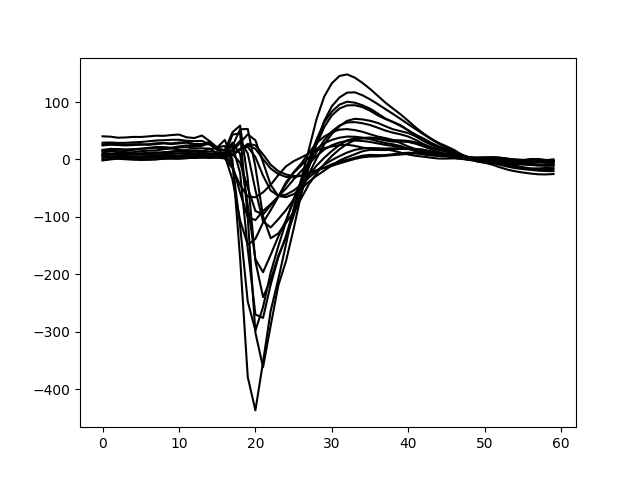

In [69]:
# let's plot a template
fig = plt.figure()
_ = plt.plot(template0, color="k")

### Exercise 5b) Find `widgets` for plotting waveforms

Use the `widgets` module to visualize waveform extractor objects.
  * plot_unit_waveforms_density_map()
  * plot_unit_waveforms()
  * plot_unit_templates
  * plot_unit_probe_map
  * plot_unit_summary

### 5b) SOLUTION

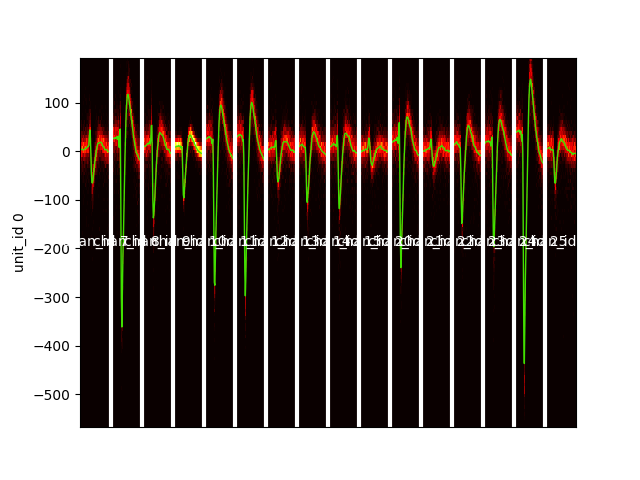

In [70]:
si.plot_unit_waveforms_density_map(we, unit_ids=[0])

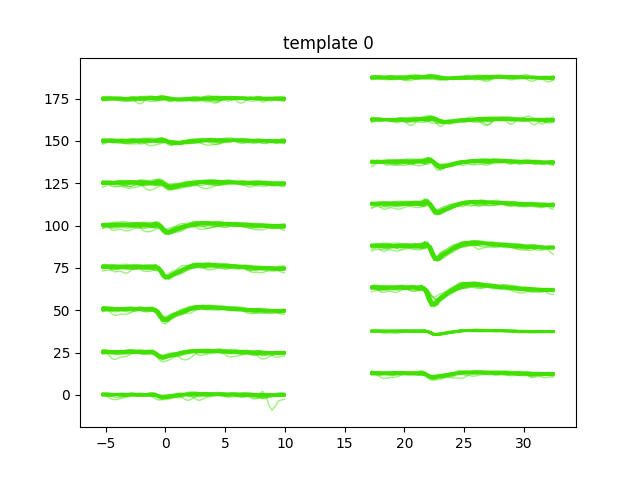

In [71]:
si.plot_unit_waveforms(we, unit_ids=[0])

In [73]:
%matplotlib widget
si.plot_unit_waveforms(we, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

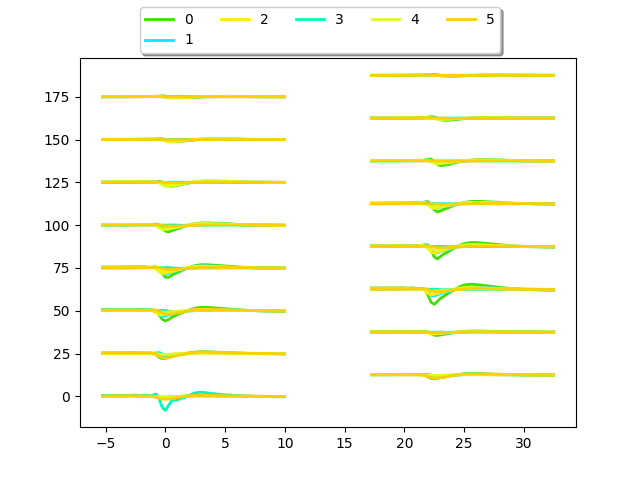

In [75]:
si.plot_unit_templates(we, unit_ids=we.unit_ids[:6], same_axis=True)

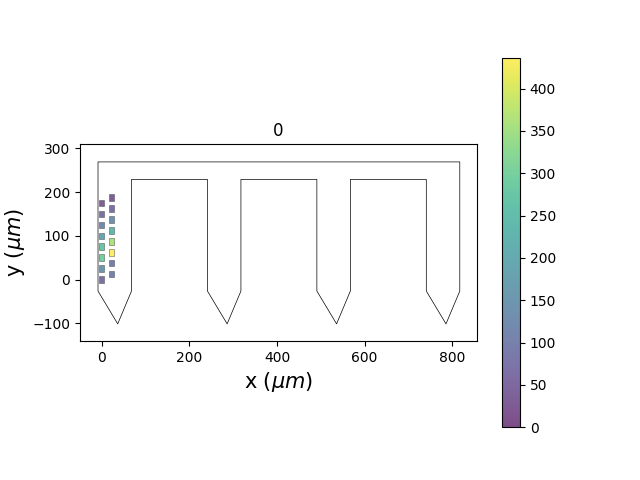

In [76]:
si.plot_unit_probe_map(we, unit_ids=[0])

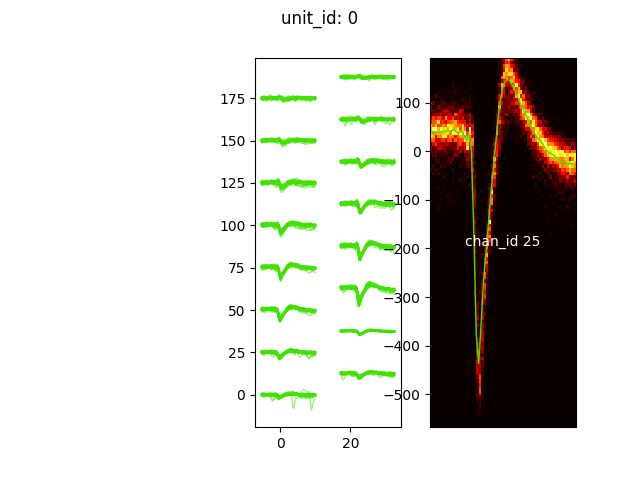

In [77]:
si.plot_unit_summary(we, unit_id=0)

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [78]:
pc = si.compute_principal_components(we, n_components=3)

Fitting PCA:   0%|          | 0/13 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/13 [00:00<?, ?it/s]

In [79]:
pc0 = pc.get_projections(unit_id=0)
# all_labels, all_pcs = pc.get_all_components()
pc0.shape

(176, 3, 16)

In [80]:
all_labels, all_pcs = pc.get_all_projections()
all_pcs.shape

(5880, 3, 16)

For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_projections()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [81]:
amplitudes = si.compute_spike_amplitudes(we, **job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

In [82]:
si.plot_amplitudes(we, backend='ipywidgets')

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

## unit locations

In [83]:
unit_loc = si.compute_unit_locations(we, method='monopolar_triangulation')

In [84]:
si.plot_unit_locations(we, backend='ipywidgets')

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

## spike locations

In [85]:
spike_loc = si.compute_spike_locations(we, method='monopolar_triangulation', **job_kwargs)

localize peaks using monopolar_triangulation:   0%|          | 0/300 [00:00<?, ?it/s]

In [86]:
si.plot_spike_locations(we, backend='ipywidgets')

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

## correlogram

In [87]:
si.compute_correlograms?

Signature:
si.compute_correlograms(
    waveform_or_sorting_extractor,
    load_if_exists=False,
    window_ms: float = 50.0,
    bin_ms: float = 1.0,
    method: str = 'auto',
)
Docstring:
Compute auto and cross correlograms.

Parameters
----------
waveform_or_sorting_extractor : WaveformExtractor or BaseSorting
    If WaveformExtractor, the correlograms are saved as WaveformExtensions.
load_if_exists : bool, default: False
    Whether to load precomputed crosscorrelograms, if they already exist.
window_ms : float, optional
    The window in ms, by default 100.0.
bin_ms : float, optional
    The bin size in ms, by default 5.0.
method : str, optional
    "auto" | "numpy" | "numba". If _auto" and numba is installed, numba is used, by default "auto"

Returns
-------
ccgs : np.array
    Correlograms with shape (num_units, num_units, num_bins)
    The diagonal of ccgs is the auto correlogram.
    ccgs[A, B, :] is the symetrie of ccgs[B, A, :]
    ccgs[A, B, :] have to be read as the histog

In [88]:
cc = si.compute_correlograms(we, window_ms=25, bin_ms=1.)

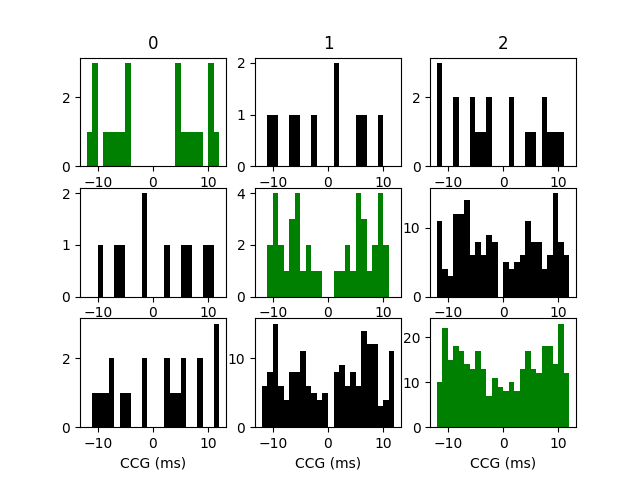

In [89]:
si.plot_crosscorrelograms(we, unit_ids=[0,1,2])

# 7. Viewers <a class="anchor" id="viewers"></a>

The `spikeinterface-gui` allows you to interactively explore a spike sorting output once waveforms are extracted.


### Exercise 7a) Use the `spikeinterface-gui` to epxlore the sorting output

Launch the `sigui` on the waveforms folder and explore all different views.

- Can you find some bad units?
- Are there missed spikes or spike sorting errors?

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

In [91]:
!sigui {base_folder}/"waveforms_TDC"

Force compute_noise_levels() this is needed


# 8.Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymertics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [92]:
print(si.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift']


In [93]:
qc = si.compute_quality_metrics(we)

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:842: UserWarning: Units [0, 3] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
/home/samuel/.virtualenvs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/samuel/.virtualenvs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/samuel/.virtualenvs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Computing PCA metrics:   0%|          | 0/13 [00:00<?, ?it/s]

In [94]:
display(qc)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,firing_range,drift_ptp,drift_std,drift_mad,isolation_distance,l_ratio,d_prime,silhouette,nn_hit_rate,nn_miss_rate
0,176.0,0.586667,1.0,26.974939,0.000000,0.0,0.000000,0.0,NaN,NaN,...,2.81,NaN,NaN,NaN,59.334693,0.370107,4.435558,0.283457,0.919034,0.000964
1,1655.0,5.516667,1.0,11.989635,0.000000,0.0,0.000000,0.0,0.075,0.000430,...,5.65,1.169859,0.434686,0.368420,122.245793,0.239895,3.749028,0.196650,0.812000,0.023048
2,2595.0,8.650000,1.0,12.708482,0.193049,13.0,0.226016,9.0,0.255,0.000824,...,6.84,6.043791,2.535528,2.443702,86.004008,0.383668,3.376213,0.172182,0.696500,0.029647
3,204.0,0.680000,1.0,30.189825,0.000000,0.0,0.000000,0.0,NaN,NaN,...,2.42,NaN,NaN,NaN,193.282841,0.001582,11.127457,0.198351,0.840686,0.001057
4,7333.0,24.443333,1.0,7.989527,0.247337,133.0,0.160767,53.0,0.155,0.000118,...,19.10,0.841620,0.327179,0.304732,66.609017,0.355124,3.689050,0.219643,0.797500,0.021561
5,2642.0,8.806667,1.0,9.660016,0.171916,12.0,0.113938,5.0,0.200,0.000707,...,13.58,1.795362,0.649911,0.464822,78.094947,0.072014,4.190120,0.132195,0.808500,0.021375
6,1120.0,3.733333,1.0,9.716370,0.797194,10.0,1.000000,7.0,NaN,0.000633,...,11.82,2.262791,0.413264,0.743168,56.574182,0.536222,4.065748,0.087061,0.639500,0.021283
7,9148.0,30.493333,1.0,10.302152,0.325025,272.0,0.401406,179.0,0.335,0.000057,...,23.29,0.457279,0.156227,0.090302,75.740261,0.110021,4.766661,0.246382,0.866000,0.013290
8,2249.0,7.496667,1.0,10.078884,0.138395,7.0,0.197424,6.0,0.235,0.000478,...,18.87,1.516085,0.572972,0.465635,75.650714,0.129150,3.036659,0.183684,0.804000,0.028532
9,4081.0,13.603333,1.0,5.270256,0.744541,124.0,1.000000,83.0,NaN,0.000423,...,21.47,6.381276,2.283949,1.222781,45.503456,1.279087,1.979615,0.072812,0.485500,0.046608


For more information about these waveform features, we refer to this 2 doc

  * [Allen documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from Josh Siegle.

  * [spikeinterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) from SI team

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qc` dataframe based on some thresholds.

Here, we'll only keep units with an SNR > 5 and an ISI violation threshold < 0.2:

In [102]:
qc[['snr', 'isi_violations_ratio']]

,snr,isi_violations_ratio
0,26.974939,0.000000
1,11.989635,0.000000
2,12.708482,0.193049
3,30.189825,0.000000
4,7.989527,0.247337
5,9.660016,0.171916
6,9.716370,0.797194
7,10.302152,0.325025
8,10.078884,0.138395
9,5.270256,0.744541


In [95]:
snr_thresh = 5
isi_viol_thresh = 0.2

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [103]:
our_query = f"snr > {snr_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

snr > 5 & isi_violations_ratio < 0.2


and then we can use the query to select units:

In [104]:
keep_units = qc.query(our_query)
keep_unit_ids = keep_units.index.values

In [106]:
sorting_auto = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

Number of units before curation: 13
Number of units after curation: 6


### 8a) Extract waveforms on the curated sorting and explore the output in the spikeinterface-gui

Re-extract waveforms using the curated output and explore the results.

Is the spike sorting quality improved?

### 8a) SOLUTION



In [107]:
# choose a different folder!
we_curated = si.extract_waveforms(recording_saved, sorting_auto, folder=base_folder/"waveforms_si_curated",
                                  progress_bar=True, n_jobs=1, total_memory="500M", overwrite=True)
print(we_curated)

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

WaveformExtractor: 16 channels - 6 units - 1 segments
  before:20 after:40 n_per_units:500 - sparse


In [109]:
!sigui {base_folder}/waveforms_si_curated

Force compute_noise_levels() this is needed


# 9. Exporters <a class="anchor" id="exporters"></a>

The `exporters` module provides functions to export the spike sorting results to different frameworks.

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [200]:
from spikeinterface.exporters import export_to_phy

In [110]:
# export_to_phy(we_curated, output_folder=base_folder/'phy', **jopb_kwargs)

In [111]:
# %%capture --no-display
# !phy template-gui phy/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [179]:
# sorting_phy_curated = se.PhySortingExtractor('phy/', exclude_cluster_groups=['noise'])

In [112]:
# print(f"Number of units before curation: {len(sorting_auto.get_unit_ids())}")

# Manually labeled 3 units as noise
# print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")

## Export spike sorting report

The SpikeInterface report automatically saves summary and unit-specific views to save and inspect your spike sorting output.

In [117]:
%%capture --no-display
si.export_report(waveform_extractor=we_curated, output_folder=base_folder/"SI_report", format="png")